In [28]:
import sys
from pathlib import Path
import json

import pandas as pd
import numpy as np
import gtfstk as gt
import shapely.geometry as sg
import shapely.ops as so
import folium as fl

sys.path.append('../')

import make_gtfs as mg


DATA_DIR = Path('../data')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import shapely.wkt as sw
import shapely.ops as so

#s = sg.shape(pfeed.shapes['features'][0]['geometry'])
s = sw.loads("LINESTRING(0 0, 0.2 0.1, 0.3 0.6, 0.4 0.1, 1 1)")
#s = sg.LineString([(x, y) for x, y in reversed(s.coords)])

eps = 10e-3
b0 = s.buffer(eps, cap_style=3)
b1 = s.buffer(0.05, cap_style=2)
diff = b1.difference(b0)
left, right = list(so.polygonize(diff))


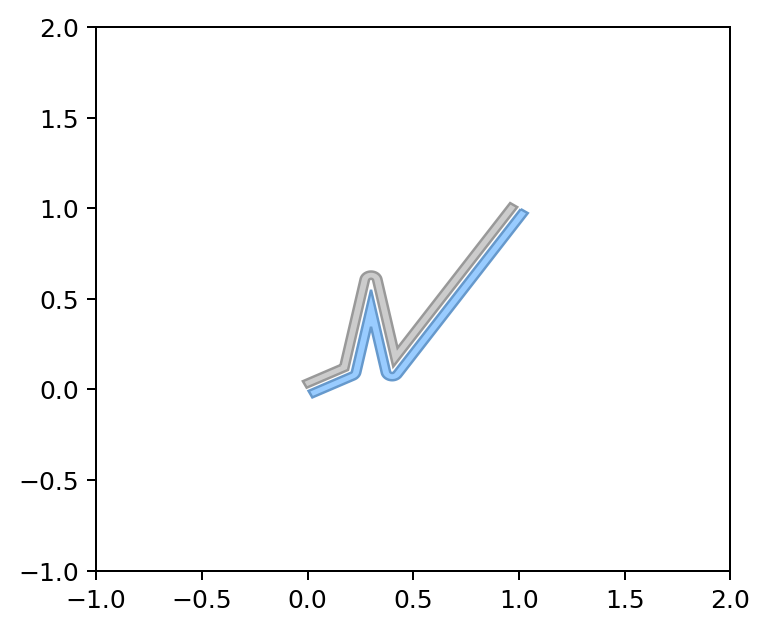

In [30]:
from matplotlib import pyplot
from shapely.geometry import LineString
from descartes.patch import PolygonPatch

fig = pyplot.figure(1, figsize=(10, 4), dpi=180)


ax = fig.add_subplot(121)
patch2a = PolygonPatch(left, facecolor='#cccccc', edgecolor='#999999')
ax.add_patch(patch2a)
patch2b = PolygonPatch(right, facecolor='#99ccff', edgecolor='#6699cc')
ax.add_patch(patch2b)

ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)

pyplot.show()

In [4]:
pfeed = mg.read_protofeed(DATA_DIR/'auckland')


In [39]:
# Visually test geometrize_stops()

# Compute
shid = 'shp2-1'
shapes = mg.build_shapes(pfeed)
stops = mg.build_stops(pfeed)
geo_shapes = gt.geometrize_shapes(shapes, use_utm=True)
geo_stops = gt.geometrize_stops(stops, use_utm=True)

linestring = geo_shapes.loc[lambda x: x['shape_id'] == shid, 'geometry'].iat[0]
stops_by_side = {
    side: mg.get_nearby_stops(geo_stops, linestring, side, buffer=15).to_crs(gt.WGS84)
    for side in ['left', 'right', 'both']
}

# Plot
collection_by_side = {side: json.loads(stops.to_json()) 
  for side, stops in stops_by_side.items()}
center = list(stops_by_side['left'].geometry.iat[0].coords[0])[::-1]
my_map = fl.Map(location=center, zoom_start=13, tiles='cartodbpositron')


# Path
collection = json.loads(geo_shapes.to_crs(gt.WGS84).to_json())
f = [f for f in collection['features'] if f['properties']['shape_id'] == shid][0]
prop = f['properties']
prop['color'] = 'black'
path = fl.GeoJson(f,
    name=prop['shape_id'],
    style_function=lambda x: {
      'color': x['properties']['color']},
)
path.add_to(my_map)

# Stops
color_by_side = {
    'left': 'blue',
    'right': 'red',
    'both': 'gray',
}
radius_by_side = {
    'left': 5,
    'right': 5,
    'both': 8,
}
for side in stops_by_side:
    color = color_by_side[side]
    radius = radius_by_side[side]
    for f in collection_by_side[side]['features']:
        prop = f['properties']
        if f['geometry']['type'] == 'Point':
            lon, lat = f['geometry']['coordinates']
            fl.CircleMarker(
                location=[lat, lon],
                radius=radius,
                fill=False,
                color=color,
                weight=2,
            ).add_to(my_map)

my_map

In [25]:
feed = mg.build_feed(pfeed)


In [26]:
prefix = 't-rB-weekday_peak_1-07:00:00'
t = (
    feed.trips
    .loc[lambda x: x.trip_id.str.startswith(prefix)]
)
tids = [t.trip_id.iat[0], t.trip_id.iat[-1]]
feed.map_trips(tids)
    

In [27]:
feed.validate()

,type,message,table,rows
0,warning,Feed expired,calendar,[]
